# Table of Contents


In [1]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import ipywidgets as widgets
import sys, os, io, string, shutil, math
from hublib.ui import Submit
from hublib.ui import RunCommand
import hublib.use
%use boost-1.62.0-mpich2-1.3-gnu-4.7.2
#%use lammps-31Mar17
%set_env OMP_NUM_THREADS=8
import numpy as np
import re
import time
from threading import Thread
from io import StringIO
from ipywidgets import Layout, Box, Label, Output
from IPython.display import display,HTML
sys.path.append('../python/')
#import train as nn
from dump import dump
from xyz import xyz
from svg import svg
import random
#from IPython.core.display import display, HTML
display(HTML("<style>.container { width:1300px !important; }</style>"))

style = {'description_width': 'initial'}

left_column='340px'
right_column='940px'
app_width='1280px'

form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between',
    padding='5px'
)

form_item_layout_slider_text = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between',
    padding='5px'
)

box_layout_image=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    #width='25%',
    padding='5px',
    #min_height='20px',
    #min_width='200px'
    width=left_column,
    height='304.5px'
)
box_layout_phisical=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    #width='25%',
    padding='5px',
    #min_height='20px',
    #min_width='200px'
    width=left_column,
    #height='180px'
)
box_layout_computing=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    padding='5px',
    width=left_column,
    #height='103px'
)
box_layout_progress=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    padding='5px',
    width=left_column,
    ##height='55px'
)

box_layout_output=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    padding='5px',
    width=left_column,
    #height='150px'
)
box_layout_about=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    padding='5px',
    width=right_column,
    #height='136px'
)
form_item_layout_tab = Layout(
    display='flex',
    flex_flow='column',
    align_items='stretch',
    justify_content='space-between',
    padding='5px'
)

box_layout_tabs=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    padding='5px',
    width=right_column,
    height='100%'
)

button_hide_layout=Layout(
    visibility='hidden', #visible/hidden
    padding='5px',
    
)
button_show_layout=Layout(
    visibility='visible', #visible/hidden
    padding='5px',
    
)

<IPython.core.display.Javascript object>

env: OMP_NUM_THREADS=8


In [2]:
%%html
<style>
.jupyter-widgets.widget-tab > .p-TabBar .p-TabBar-tab {
    flex: 0 1 175px
}
</style>

In [3]:
charge = widgets.BoundedIntText(
    value=600,
    min=300,
    max=600,
    step=10,
    description='Charge (Q in e)',
    style=style,
)


In [4]:
bendingModulus = widgets.BoundedIntText(
    value=10,
    min=10,
    max=50,
    step=10,
    description="Bending Modulus (K_b)",
    style=style
)

In [5]:
stretchingModulus = widgets.BoundedIntText(
    value=50,
    min=50,
    max=150,
    step=10,
    description="Stretching Modulus (K_s)",
    style=style
)


In [6]:
salt = widgets.BoundedFloatText(
    value=0.005,
    min=0.005,
    max=0.1,
    step=0.005,
    description='Salt Concentration (M):',
    style=style
)

In [7]:
steps = widgets.BoundedIntText(
    value=10000,
    min=10000,
    max=150000,
    step=10000,
    description='Simulation steps:',
    style=style
)

In [8]:
imageSlider = widgets.IntSlider(
    value=0,
    min=0,
    max=0,
    step=1000,
    description='Images',
    style=style
)

def onSliderChange(b):
    
    index = int(imageSlider.value/imageSlider.step)
    
    #if value==0:
    #    valueText = "000"
    
    #fileName="image."+valueText+".jpg"
    #fileName="outfiles/"+fileName;
    
    try:
        index_str = str(index) if index>999 else ( '0'+str(index) if index>99 else ('00'+str(index) if index >9 else '000'+str(index)))
        file = open("simulation_snapshots/image"+index_str+".svg", "rb")
        image_svg = file.read().decode('utf-8')
        output_image.clear_output()
        with output_image:
            display(HTML(image_svg))
                    
    except:
        sys.stderr.write('Image file is not there yet.')
       
    
imageSlider.observe(onSliderChange, names='value')


In [9]:
submit_str = ''
def onToggleBtnChange(b):
    global submit_str
    if clustorMode.value:
        clustorMode.icon = 'check' 
        clustorMode.button_style='success'
        if not submit_str:
            output_image_warning_text.layout.visibility = 'visible'
    else:
        clustorMode.icon = '' 
        clustorMode.button_style=''
        if not submit_str:
            output_image_warning_text.layout.visibility = 'hidden'

'''
clustorMode =widgets.ToggleButton(
    value=False,
    description='Cluster mode',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Simulation will run on a computing cluster when this button is turned on but you will loose the access to dynamic simulation snapshot slider.',
    icon='',
    style=style
)
'''

clustorMode =widgets.Checkbox(
    value=False,
    description='Cluster mode',
    disabled=False,
    #button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Simulation will run on a computing cluster when this button is turned on but you will loose the access to dynamic simulation snapshot slider.',
    icon='',
    style=style
)


clustorMode.observe(onToggleBtnChange,'value')

In [10]:
play_trigger = False

def play_btn_thread():
    global play_trigger
    imageSlider.value = 0
    while play_trigger:
            imageSlider.value = (imageSlider.value + imageSlider.step) % (imageSlider.max + imageSlider.step)
            time.sleep(1)
    
def onPlayBtnChange(b):
    global play_trigger
    global submit_str
    if playMode.value:
        playMode.button_style = 'success'
        play_trigger = True
        t = Thread(target=play_btn_thread)
        t.start()
        
    else:
        imageSlider.value=0
        playMode.button_style = ''
        play_trigger = False
            

playMode =widgets.ToggleButton(
    value=False,
    description='Play snapshots',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Simulation snapshots will be played as a gif when this button is turned on',
    icon='',
    style=style
)

playMode.observe(onPlayBtnChange,'value')


In [11]:
label_style = "style='background-color: #9ae09a; font-size:500; padding: 2px'"
label_style2 = "style='font-size:350; padding: 2px; font-weight: bold; align: center'"
def make_label(name, label_style, desc="",):
    lval = '<p %s %s>%s</p>' % (desc, label_style, name)
    return widgets.HTML(lval)

plabel = make_label('Input Parameters', label_style, '')
clabel = make_label('Computing Parameters',label_style, '')
olabel = make_label('Output Controllers', label_style, '')
imageSliderabout = make_label('Slide to navigate the simulation snapshots', label_style2, '')

In [12]:
'''
image_html = widgets.HTML(
    value='<img src="../images/overview.jpg" style="width: 500px"/>',
)
'''
file = open("../images/overview.png", "rb")
image = file.read()
image=widgets.Image(
    value=image,
    format='jpg',
    width=297,
    height=297,
)

form_items = [
    Box([image], layout=form_item_layout)
]

mainImage = Box(form_items, layout=box_layout_image)

In [13]:
form_items = [
    Box([plabel], layout=form_item_layout),
    Box([charge], layout=form_item_layout),
    Box([bendingModulus], layout=form_item_layout),
    Box([stretchingModulus], layout=form_item_layout),
    Box([salt], layout=form_item_layout)
]

form_items_computing = [
    Box([clabel], layout=form_item_layout),
    Box([clustorMode], layout=form_item_layout),
    Box([steps], layout=form_item_layout)
]

form_items_output = [
    Box([olabel], layout=form_item_layout),
    Box([imageSlider], layout=form_item_layout),
    Box([imageSliderabout], layout=form_item_layout)
]

physical_para = Box(form_items, layout=box_layout_phisical)
computing_para = Box(form_items_computing, layout=box_layout_computing)
output_para = Box(form_items_output, layout=box_layout_output)

In [14]:
about=widgets.Textarea(
    value='The shape of nanoparticles (NPs) determines their ability to act as targeted drug delivery carriers by modulating their biodistribution and bioavailability.  This app simulates the shape deformation of soft, charged nanoparticles (NPs) for a broad variety of NP material properties and solution conditions.  Users can input control parameters such as the NP surface charge, NP stretching modulus, NP bending modulus, and the solution ionic strength (salt concentration) screening the electrostatic drive to deform.  After running the simulation, in various output tabs users can view a snapshot of the NP showing the equilibrium shape and view plots of the minimization of the electrostatic energy and increase in the area of the NP as it deformed.  Volume of the NP is conserved, representative of a finite amount of cargo, and hydrophobic surface tension is considered negligible and fixed at 1 dynes/cm.  The range of charge, elasticities, and salt concentrations enable users to observe deformation into - at least - bowl, oblate ellipsoid (disc), and prolate ellipsoid (rod) shapes, egg-like shapes, and rigid spheres.  The app is ran using hybrid MPI/OMP parallelized C++ codes and Python post-processing and app deployment.',
    placeholder='',
    layout={'height': '192px','width': '100%'},
    disabled=True,
    style = {'font_weight': '150px'}
)

form_about = [
    Box([about], layout=form_item_layout)
]

about_text = Box(form_about, layout=box_layout_about)


In [15]:
def clear_All():
    global play_trigger
    global how_many_snapshots, previous_steps
    localOutput.value = ''
    submit_str= ''
    progressBar.value=0
    imageSlider.max=0
    imageSlider.value=0 
    #output_image.value=imageEmptyBox
    output_image.clear_output()
    movie_download.layout = area_download.layout = energy_file_1.layout = energy_file_2.layout = button_hide_layout
    clustorMode.disabled = False
    
    playMode.value = False
    how_many_snapshots=0
    play_trigger = False
    previous_steps = 0
    playMode.layout.visibility = 'hidden'
    
    if clustorMode.value:
        output_image_warning_text.layout.visibility = 'visible'
    else:
        output_image_warning_text.layout.visibility = 'hidden'
        
    plt.figure('Area vs. time')
    plt.clf()  # clear old plot
    plt.figure('Energy Conservation of the System')
    plt.clf()  # clear old plot
    
    

In [16]:
def runPreprocessor(npCharge_value, nLigand_value, salt_value):
    pass
'''
    preprocessingCMD = "./preprocessor -Q "+str(npCharge_value)+" -n "+str(nLigand_value)+" -c "+str(salt_value) + " > preprocessor.log"
    
    try:
        !$preprocessingCMD
        
    except  Exception as e:
        localOutput.value = localOutput.value + "Error occured during the execution of preprocessing executable\n"
        sys.stderr.write('Error occured during the execution of preprocessing executable')
        sys.stderr.write(str(e))
        sys.exit(1)
'''    


'\n    preprocessingCMD = "./preprocessor -Q "+str(npCharge_value)+" -n "+str(nLigand_value)+" -c "+str(salt_value) + " > preprocessor.log"\n    \n    try:\n        !$preprocessingCMD\n        \n    except  Exception as e:\n        localOutput.value = localOutput.value + "Error occured during the execution of preprocessing executable\n"\n        sys.stderr.write(\'Error occured during the execution of preprocessing executable\')\n        sys.stderr.write(str(e))\n        sys.exit(1)\n'

In [17]:
runFlag=False
working_dir=""
parameter_append=""
sim_bigin=False
build_Plots=True
simulation_params=""

def callExe(s):
    global runFlag, working_dir, parameter_append, sim_bigin, ionsplot, build_Plots, simulation_params, nLigand_value, runName, simulationStepsToatal
    global submit_str
    if build_Plots:
        showPlotUI()
        build_Plots = False
    clear_All()
    
    #clustorMode.disabled = True
    
    localOutput.value = localOutput.value + "Simulation begins...\n"
     
    charge_value = charge.value
    bendingModulus_value = bendingModulus.value
    stretchingModulus_value = stretchingModulus.value
    salt_value = salt.value
    simulationStepsToatal = steps.value
    aneal_freq = int(simulationStepsToatal*0.1)

    total_processors = 96
    omp_size = 24
    
    '''
    following are for 96 processors (4*24) in brown cluster
    20min: 67,500 steps
    for 150,000 steps := 45 mins
    10,000 := 3mins
    '''
    walltime = 5 + int(simulationStepsToatal/10000*3)
    
    runName='npshape'
    
    #Adding standard outputs to string to be sent to output widget callback function
    parameter_append= "Charge(Q in e) is "+ str(charge_value)+"\n"
    parameter_append= parameter_append + "Bending Modulus is "+ str(bendingModulus_value)+"\n"
    parameter_append= parameter_append + "Stretching Modulus is "+ str(stretchingModulus_value)+"\n"
    parameter_append= parameter_append + "Salt Concentration (M) is "+ str(salt_value)+"\n"
    
    if clustorMode.value:
        parameter_append= parameter_append + "requested walltime is "+ str(walltime)+" (mins)\n"
        parameter_append= parameter_append + "requested total processors are "+ str(total_processors)+"\n"
    
    simulation_params="_%d" % int(charge_value)+"_%d" % int(bendingModulus_value)+"_%d" % int(stretchingModulus_value)+"_%.2f" % float(salt_value)

    shutil.rmtree('outfiles',True)
    if not os.path.exists('outfiles'):
        os.makedirs('outfiles')
     
    #ocalOutput.value = localOutput.value + "Preprocessing is running...\n"
    
    #preprocessing stage
    #unPreprocessor(npCharge_value, nLigand_value, salt_value)
    
    #ocalOutput.value = localOutput.value + "Preprocessing completed\n"
        
    localOutput.value = localOutput.value +  parameter_append;
    
    
    #submit_para_list = '--venue ' + str(cluster_name) + ' -w '+ str(walltime)+' -n '+str(total_processors) \
    # ' -N ' + '16 ' + ' --tailStdout 1000 ' + '--inputfile ' + 'data ' + 'nanoconfinement-r32 '
     
    prog_paraList = ' -R 10 -D 4 –t 1.0 -G V -d 0.0005 -T 0.0005 –f '+ str(aneal_freq)+' -q '+str(charge_value) \
    +' -b '+str(bendingModulus_value)+' -s '+str(stretchingModulus_value)+' -c '+ str(salt_value) \
    + ' -S ' +str(simulationStepsToatal)

    runFlag=True
    sim_bigin=True
    
    computing_clusters = ['standby@brown','standby@rice']
    
    cluster_name = computing_clusters[random.randint(0,1)]
    
    #starting a thread for on the fly density plot
    #t2 = Thread(target=iterative_density_plot)
    #t2.start()
    
    try:
        #rname = s.make_rname(e_np_value, e_out_value, pion_value, c_out_value, np_radius_value, np_charge_value, sim_steps_value)
        submit_str = ''
        if clustorMode.value:
            submit_str = '--venue standby@brown -n '+str(total_processors)+' -N ' +str(omp_size)+' -w '+str(walltime)+' -e OMP_NUM_THREADS=' + str(omp_size) \
            +' --tailStdout 1000 ' +'--inputfile '+'infiles '+'--inputfile '+'outfiles '+'npshapelab-r126'
            
            #submit_str = '-n '+str(total_processors)+' -w '+str(walltime)+' -N 20'+' -e OMP_NUM_THREADS=1'+' --tailStdout 1000 ' +'--inputfile '+'outfiles '+'lammps-31Mar17-parallel -in in.lammps' 
            #submit_str = '--venue standby@rice ' + '-n 32 -w 60 -N 16'+' --tailStdout 1000 ' +'--inputfile '+'outfiles '+'lammps-31Mar17-parallel -in in.lammps'
            localOutput.value = localOutput.value + "Simulation is submitted to the cluster, waiting for response...\n"
        else:
            submit_str = '--local stdbuf -o0 -e0 ./np_shape_lab' + prog_paraList
            
            localOutput.value = localOutput.value + "Simulation is running...\n"

        s.run(runName, submit_str)
        
        time.sleep(1)
        
    except  Exception as e:
        sys.stderr.write('Error occured during the execution of np-shape program')
        sys.stderr.write(str(e))
        sys.exit(1)
    
    runFlag = False
    #t2.join()

In [18]:
def doneFunc(s, rdir):
    global submit_str
    global how_many_snapshots
    #this is a condtional variable for few things
    submit_str = ''
    
    progressBar.value=int(100)
    
    localOutput.value = localOutput.value + "Simulation finished\n" 
    
    submit_btn.but.disabled = True
    clustorMode.disabled = False
    
    
    '''
    localOutput.value = localOutput.value + "Postprocessing is running...\n"
    
    #postprocessing stage
    
    postprocessingCMD = "./postprocessor -n "+str(nLigand_value)+" -N 150 > postprocessor.log"
    try:
        !$postprocessingCMD
        
    except  Exception as e:
        localOutput.value = localOutput.value + "Error occured during the execution of postprocessing executable\n"
        sys.stderr.write('Error occured during the execution of postprocessing executable')
        sys.stderr.write(str(e))
        sys.exit(1)
        
    localOutput.value = localOutput.value + "Postprocessing is finished\n"
    '''
    
    #  Plotting the result
    plot_data()
    energy_plot()
    how_many_snapshots=dump_svgs()
    localOutput.value = localOutput.value + "Number of simulation snapshots generated="+str(how_many_snapshots)+"\n"
    localOutput.value = localOutput.value + "Post processing ended\n"
    
    submit_btn.but.disabled = False
    playMode.layout.visibility = 'visible'
    
    #image slider fully ready
    imageSlider.max=int(simulationStepsToatal/imageSlider.step)*imageSlider.step
    #imageSlider.max=(how_many_snapshots-1)*imageSlider.step
    imageSlider.value=int(simulationStepsToatal/imageSlider.step)*imageSlider.step
    #imageSlider.value=int(how_many_snapshots)-1
    
    movie_download.layout = area_download.layout = energy_file_1.layout = energy_file_2.layout = button_show_layout

In [19]:
# after the run finished, optionally do something
# with the output
#def plot_data(s, rdir):
def plot_data():    
    #We ignore rdir because submit puts non-parametric runs in the current directory
    # When caching is enabled, they get put in a chached directory and rdit is always used. 
    #wait for 2 seconds before plotting errorBars.
    time.sleep(0.5)  
    plt.figure('Area vs. time')
    plt.clf()  # clear old plot
    plt.title('Area profile of the nanoparticles')
    plt.xlabel('Simulation Time Steps', fontsize=10)
    plt.ylabel('Area', fontsize=10)
    
    # our simulation writes to outfiles -> density_profile.dat
    try:
        areafile = np.loadtxt(working_dir + 'outfiles/area.dat')
    except:
        sys.stderr.write('Can not find the area.dat file')
        sys.exit(1)
    #print(density_profile)    
    x = areafile[:,0]
    # droping data above 4.3 in x dim.
    #x = numpy.select([ x < 4.3 ],x)
    y = areafile[:x.size,1]
    #yrr = density_profile[:,2]
    #plt.errorbar(x,y,xerr=0.0, yerr=yrr, c='b', ecolor='r', capsize=2)
    plt.plot(x,y)
    plt.show()
    

def energy_plot():
    time.sleep(0.5)
    plt.figure('Energy Conservation of the System')
    plt.clf()  # clear old plot
    plt.title("Energy profiles for the simulation")
    plt.xlabel('Simulation Time Steps', fontsize=10)
    plt.ylabel('Energy(KBT)', fontsize=10)
    
    
    try:
        
        energy_profile = np.genfromtxt(working_dir + 'outfiles/energy_nanomembrane.dat')
        es_energy_profile = np.genfromtxt(working_dir + 'outfiles/energy_in_parts_kE_bE_sE_tE_ljE_esE.dat')

        #removing Nan rows
        #energy_profile[~np.isnan(energy_profile).any(axis=1)]
        #es_energy_profile[~np.isnan(es_energy_profile).any(axis=1)]

        step = energy_profile[:,0]
        total_en = energy_profile[:,4]
        electrostatic_en = es_energy_profile[:,6]
        lj_en = es_energy_profile[:,5]
        #potential = energy_profile[:,3]
        #kinetic_virtual = energy_profile[:,4]

        plt.plot(step,total_en, color='red', label='Global net energy')
        plt.plot(step,electrostatic_en, color='green', label='Electrostatic energy')
        plt.plot(step,lj_en, color='blue', label='Lennard-Jones potential energy')
        #plt.plot(step,potential, color='blue', label='Potential')
        #plt.plot(step,kinetic_virtual, color='yellow', label='Kinetic (virtual)')
        plt.legend()
        plt.show()
        
    except  Exception as e:
        sys.stderr.write('Can not find the energy files')
        sys.stderr.write(str(e))

In [20]:
def dump_svgs(filepath='outfiles/p.lammpstrj', skip_factor=1):
    
    shutil.rmtree('simulation_snapshots',True)
    if not os.path.exists('simulation_snapshots'):
        os.makedirs('simulation_snapshots')
    
    data = dump(filepath)
    data.map(1,"id")
    data.tselect.skip(skip_factor)
    t = data.time()
    #print(t)
    #if len(t)>500:
    #    skip_factor = 10
    #    data.tselect.skip(skip_factor)
    #t = data.time()
        
    s = svg(data)
    s.bg("white")               #set background color (def = "black")
    s.size(450)               #set image size to NxN
    #s.size(N,M)               #set image size to NxM
    #s.rotate(60,135)               #view from z theta and azimuthal phi (def = 60,30)
    s.rotate(55, 60) 
    s.shift(0, 0)               #translate by x,y pixels in view window (def = 0,0)
    s.zoom(0.8)               #scale image by factor (def = 1)
    s.box(0)               #0/1/2 = none/variable/fixed box
    #s.box(0/1/2,"green")               #set box color
    #s.box(0/1/2,"red",4)               #set box edge thickness
    s.acol(1,"red")
    s.arad(1,0.09)
    s.file = "simulation_snapshots/image"               #file prefix for created images (def = "image")
    s.all()
    #file_content = s.show(time_index)               #show image of snapshot at timestep N
    #return file_content
    #return SVG(file_content)
    #return display(SVG(file_content))
    return len(t)   # how many images are generated

In [21]:
in_wrapper_progress = False
saved_data = ""
saved_data_enery = ""
saved_data_ions_pos = ""
stepNumber = 0
previous_steps = 0

def stdoutput_handler(buffer):
    global in_wrapper_progress, saved_data, parameter_append, sim_bigin, stepNumber, saved_data_enery, saved_data_ions_pos, simulationStepsToatal
    global previous_steps
    output = []

    #return buffer

    if sim_bigin:
        #output.append(parameter_append)
        sim_bigin = False
   
    data = buffer.split('\n')
    
    last = len(data) - 1
    
    for i, line in enumerate(data):
        
        number = line.split('%')
        if number:
            if number[0].strip().isdigit():
                #print(number[0].strip())
                percent = float(number[0].strip())     #/simulationStepsToatal*100
                progressBar.value=int(percent)
                # This adjust the image slider dynamically
                # dynamic update only happens for local VM run
                if submit_str.startswith('--local '):
                    number_of_steps =int(int(percent)*simulationStepsToatal/100)
                    if(number_of_steps%imageSlider.step == 0) and number_of_steps!=previous_steps:
                        previous_steps=number_of_steps
                        #print(number_of_steps)
                        how_many_snapshots=dump_svgs()
                        imageSlider.max=int(number_of_steps)
                        imageSlider.value=int(number_of_steps)
                        # refreash area and energy plots
                        dynamic_refresh()
            else:
                if '%' not in line and '|' not in line:
                    output.append(line)
      
    reduced_buffer = '\n'.join(output)
    
    #appending new line at the end
    if reduced_buffer:
        if reduced_buffer[-1] != '\n':
            reduced_buffer = reduced_buffer + '\n'
    
    return reduced_buffer

In [22]:
#button_style = "style='background-color: #81c4fd; font-size:500; padding: 4px; -webkit-appearance: button; -moz-appearance: button; appearance: button; text-decoration: none; color: initial;'"

def make_downloadBtn(downFilename="", downloadURL="", displayText=""):
    bval = "<a download='%s' href='%s'><button class='p-Widget jupyter-widgets jupyter-button widget-button mod-info'>%s</button></a>" % (downFilename, downloadURL, displayText)
    return widgets.HTML(bval)

#from IPython.display import FileLink, FileLinks
#FileLinks('outfiles')
#FileLinks('data')

<IPython.core.display.Javascript object>


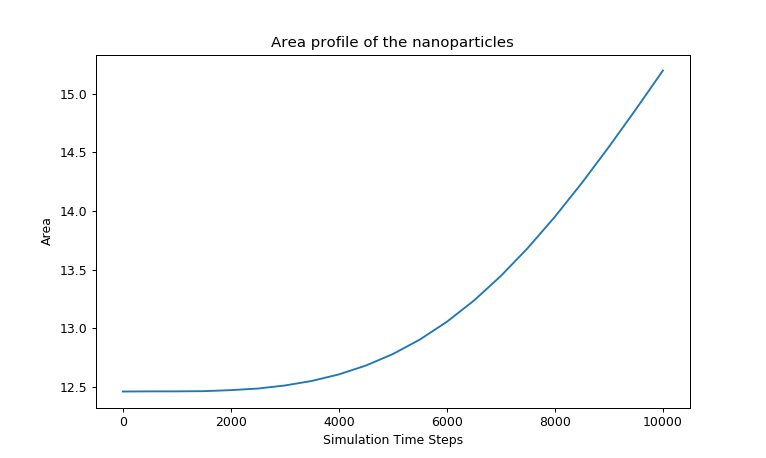

<IPython.core.display.Javascript object>


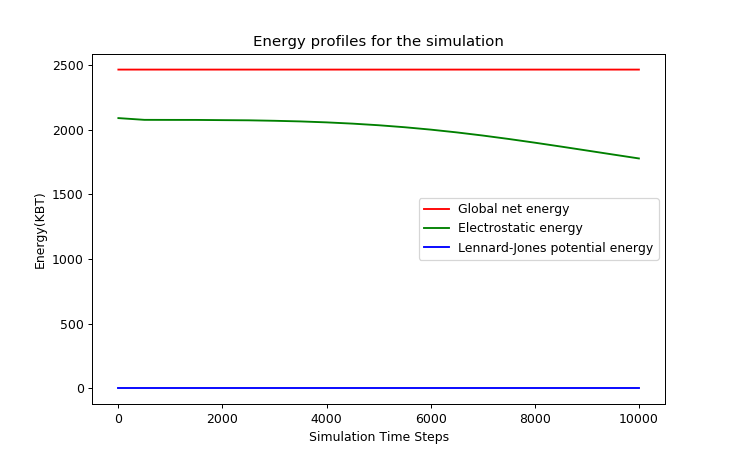

In [23]:
tab_layout=Layout(
    width='100%',
    height='600px',
    justify_content='space-between',
)

# we want the plot to go here, so create an empty one initially
#create tabs
figsize_tup=(8.50, 5.0)
figure_area_time = plt.figure(num='Area vs. time', figsize=figsize_tup)
out_area_time = Output(layout=tab_layout)

figure_energy = plt.figure(num='Energy Conservation of the System', figsize=figsize_tup)
out_energy = Output(layout=tab_layout)


'''
#file = open("../images/image.emptybox.jpg", "rb")
file = open("simulation_snapshots/image0000.svg", "rb")
imageEmptyBox = file.read()
output_image=widgets.Image(
    format='svg',
    width=584,
    height=584,
    value=imageEmptyBox.decode('utf-8')
)
#out_output_image = Output(layout=tab_layout)
'''

output_image = Output(layout=tab_layout)


output_image_layout=Layout(
    display='flex',
    flex_flow='row',
    #border='solid 2px',
    align_items='stretch',
    margin = '0px 0px 0px 105px' #top, right, bottom and left
)

box_layout_warning_text=Layout(
    display='flex',
    flex_flow='column',
    #border='solid 1px',
    align_items='stretch',
    padding='5px',
    width='150px',
    visibility = 'hidden',
    height='95%'
)
box_layout_playbtn=Layout(
    display='flex-end',
    flex_flow='row',
    #border='solid 1px',
    align_items='stretch',
    padding='5px',
    width='150px',
    visibility = 'hidden',
    #height='136px'
)

#label_style3 = "style='background-color: #eeeeee; color: #388e3c; font-size:350; padding: 2px; font-weight: bold; align: center'"
label_style3 = "style='background-color: #eeeeee; font-size:350; padding: 2px; font-weight: bold; align: center'"
output_image_warning_text = make_label('Cluster mode is on! You will lose access to the dynamic simulation snapshot data. Snapshot data will be available at the end of simulation.', label_style3, '')

box_layout_for_right = Layout(
    display='flex',
    flex_flow='column',
    align_items='stretch',
    #border='solid',
    height='100%',
    #width='150px',
    #width='50%'
)

form_output_image_sec_right_items = [
    Box([output_image_warning_text], layout=box_layout_warning_text),
    Box([playMode], layout=box_layout_playbtn),

]

form_output_image_sec_right = Box(form_output_image_sec_right_items, layout=box_layout_for_right)

output_image_box =  Box([output_image], layout=output_image_layout)

form_output_image_sec = [
    Box([output_image_box], layout=output_image_layout),
    Box([form_output_image_sec_right], layout=box_layout_for_right),

]

output_image_section = Box(form_output_image_sec, layout=tab_layout)

#data download tab
movie_download = make_downloadBtn(downFilename="movie.xyz", downloadURL="outfiles/p.lammpstrj", displayText="Movie")
area_download = make_downloadBtn(downFilename="area.dat", downloadURL="outfiles/area.dat", displayText="NP Area Info.")
energy_file_1 = make_downloadBtn(downFilename="NP_energy.dat", downloadURL="outfiles/energy_nanomembrane.dat", displayText="NP Energy")
energy_file_2 = make_downloadBtn(downFilename="energy_in_parts.dat", downloadURL="outfiles/energy_in_parts_kE_bE_sE_tE_ljE_esE.dat", displayText="Energy in parts")


movie_download.layout = area_download.layout = energy_file_1.layout = energy_file_2.layout = button_hide_layout

box_layout_outputs=Layout(
    display='flex',
    flex_flow='column',
    align_items='stretch',
    padding='5px'
)
form_output_content = [
    Box([movie_download], layout=box_layout_outputs),
    Box([area_download], layout=box_layout_outputs),
    Box([energy_file_1], layout=box_layout_outputs),
    Box([energy_file_2], layout=box_layout_outputs)
]
downloadMovieSec = Box(form_output_content, layout=tab_layout)



In [24]:
#tabChange detection and plot data incase automatically not drawn
def dynamic_refresh():
    if os.path.isfile('outfiles/area.dat'):
        plot_data()
    if os.path.isfile('outfiles/energy_nanomembrane.dat') and os.path.isfile('outfiles/energy_in_parts_kE_bE_sE_tE_ljE_esE.dat'):
        energy_plot() 

def onTabChange(b):
    dynamic_refresh()
        

In [25]:
tab_contents = ['Area vs. time', 'Energy Conservation', 'Simulation Snapshot', 'Downloads']
children = [out_area_time, out_energy, output_image_section, downloadMovieSec]
tabSpace = widgets.Tab()
tabSpace.children = children
for i in range(len(children)):
    tabSpace.set_title(i, str(tab_contents[i]))
tabSpace.selected_index = 2

tabSpace.observe(onTabChange, names='selected_index')

form_about = [
    Box([tabSpace], layout=form_item_layout_tab)
]

tab = Box(form_about, layout=box_layout_tabs)

In [26]:
def showPlotUI():
    with out_area_time:
        display(figure_area_time, layout=tab_layout)
    with out_energy:
        display(figure_energy, layout=tab_layout)

In [27]:
form_item_layout_output = Layout(
    display='flex',
    flex_flow='column',
    justify_content='space-between',
    padding='4px'
)

form_item_layout_run_btn = Layout(
    display='flex',
    flex_flow='column',
    justify_content='space-between',
    padding='4px'
)

#Submit(start_func=callExe, done_func=plot_data, cachename='SubmitTest1')
submit_btn=Submit(start_func=callExe, done_func=doneFunc, outcb=stdoutput_handler)

submit_btn.acc.set_title(0, "Executable Output")
submit_btn.w.layout = form_item_layout_run_btn
#submit_btn.acc.layout = form_item_layout_output
localOutput = widgets.Textarea(layout={'width': '100%', 'height': '250px'})
localOutputWidget = widgets.Accordion(children=[localOutput],layout=form_item_layout_output)
localOutputWidget.set_title(0, "Output")
localOutputWidget.selected_index = None
localOutput.value = ""


In [28]:
progressBar=widgets.IntProgress(
    value=0,
    min=0,
    max=100,
    step=1,
    description='Progress:',
    bar_style='info', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal',
    layout={'width': '100%'},
    style=style
)

form_items_progress = [
    Box([progressBar], layout=form_item_layout)
]

progressBar_Ele = Box(form_items_progress, layout=box_layout_progress)

In [29]:
app_height='930px'

form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between',
    padding='5px'
)

box_layout_column_left=Layout(
    display='flex',
    flex_flow='column',
    #border='solid 2px',
    align_items='stretch',
    width=left_column,
    height=app_height
    #height='840px'
)
box_layout_column_right=Layout(
    display='flex',
    flex_flow='column',
    #border='solid 2px',
    align_items='stretch',
    width=right_column,
    height=app_height
    #height='840px'
)

box_layout=Layout(
    display='flex',
    flex_flow='row',
    #border='solid 2px',
    align_items='stretch',
    width=app_width,
    #padding='5px',
    height=app_height
)

box_layout_rows=Layout(
    display='flex',
    flex_flow='column',
    #border='solid 2px',
    align_items='stretch',
    width=app_width,
    #padding='5px',
    height='1950px',
    #overflow_x='scroll',
    #overflow_y='scroll'
)


gui_left = [
    Box([mainImage], layout=form_item_layout),
    Box([physical_para], layout=form_item_layout),
    Box([computing_para], layout=form_item_layout),
    Box([progressBar_Ele], layout=form_item_layout),
    Box([output_para], layout=form_item_layout)
]

gui_right = [
    Box([about_text], layout=form_item_layout),
    Box([tab], layout=form_item_layout)
]

form_left = Box(gui_left, layout=box_layout_column_left)
form_right = Box(gui_right, layout=box_layout_column_right)

gui_upper = [
    Box([form_left], layout=box_layout_column_left),
    Box([form_right], layout=box_layout_column_right)
]

form = Box(gui_upper, layout=box_layout)

gui = widgets.VBox([form, localOutputWidget, submit_btn.w],layout=box_layout_rows)


In [30]:
gui

VBox(children=(Box(children=(Box(children=(Box(children=(Box(children=(Box(children=(Box(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xe8\x00\x00\x03\xa0\x08\x02\x00\x00\x00!\xca\xcb\xb2\x00\x00\x00\tpHYs\x00\x00\x0b\x13\x00\x00\x0b\x13\x01\x00\x9a\x9c\x18\x00\x00\x0e2iTXtXML:com.adobe.xmp\x00\x00\x00\x00\x00<?xpacket begin="\xef\xbb\xbf" id="W5M0MpCehiHzreSzNTczkc9d"?> <x:xmpmeta xmlns:x="adobe:ns:meta/" x:xmptk="Adobe XMP Core 5.6-c145 79.163499, 2018/08/13-16:40:22        "> <rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"> <rdf:Description rdf:about="" xmlns:xmp="http://ns.adobe.com/xap/1.0/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:photoshop="http://ns.adobe.com/photoshop/1.0/" xmlns:xmpMM="http://ns.adobe.com/xap/1.0/mm/" xmlns:stEvt="http://ns.adobe.com/xap/1.0/sType/ResourceEvent#" xmlns:stRef="http://ns.adobe.com/xap/1.0/sType/ResourceRef#" xmp:CreatorTool="Adobe Photoshop CC (Windows)" xmp:CreateDate="2019-04-10T12:58:49-04:00" xmp:ModifyDate="2020-01-02T16:32:13-05:00" xmp:MetadataDate="2020-01-02T16:32:13-05:00" dc:format="image/png" photoshop:ColorMode="3" photoshop:ICCProfile="sRGB IEC61966-2.1" xmpMM:InstanceID="xmp.iid:b04f2d28-e18b-5746-8971-b72452dcbbe6" xmpMM:DocumentID="adobe:docid:photoshop:6c51d71d-10b3-9c40-b8d8-f14a10732b69" xmpMM:OriginalDocumentID="xmp.did:2c7b3bc3-cdb3-1f43-be7c-4bc2aa69ee0c"> <photoshop:TextLayers> <rdf:Bag> <rdf:li photoshop:LayerName="Reduce surface tension \xe2\x80\xa6 " photoshop:LayerText="Reduce surface tension \xe2\x80\xa6 "/> <rdf:li photoshop:LayerName="High surfactant -&gt; Minimal interfacial tension -&gt; disks Moderat" photoshop:LayerText="High surfactant -&gt; Minimal interfacial tension -&gt; disks Moderate surfactant -&gt; Moderate interfacial tension -&gt; rods Low surfactant -&gt; High interfacial tension -&gt; spheres "/> </rdf:Bag> </photoshop:TextLayers> <xmpMM:History> <rdf:Seq> <rdf:li stEvt:action="created" stEvt:instanceID="xmp.iid:2c7b3bc3-cdb3-1f43-be7c-4bc2aa69ee0c" stEvt:when="2019-04-10T12:58:49-04:00" stEvt:softwareAgent="Adobe Photoshop CC (Windows)"/> <rdf:li stEvt:action="converted" stEvt:parameters="from image/gif to image/png"/> <rdf:li stEvt:action="saved" stEvt:instanceID="xmp.iid:44fdcff2-39ac-6741-bbe2-ffe81d50a5ff" stEvt:when="2019-04-10T18:46:53-04:00" stEvt:softwareAgent="Adobe Photoshop CC (Windows)" stEvt:changed="/"/> <rdf:li stEvt:action="saved" stEvt:instanceID="xmp.iid:3a2b36eb-f1f4-bb45-ad20-f895494f6f1f" stEvt:when="2020-01-02T16:24:59-05:00" stEvt:softwareAgent="Adobe Photoshop CC 2019 (Windows)" stEvt:changed="/"/> <rdf:li stEvt:action="converted" stEvt:parameters="from image/png to application/vnd.adobe.photoshop"/> <rdf:li stEvt:action="derived" stEvt:parameters="converted from image/png to application/vnd.adobe.photoshop"/> <rdf:li stEvt:action="saved" stEvt:instanceID="xmp.iid:6e250518-7d0d-8d4d-9ebd-dc072cf70e56" stEvt:when="2020-01-02T16:24:59-05:00" stEvt:softwareAgent="Adobe Photoshop CC 2019 (Windows)" stEvt:changed="/"/> <rdf:li stEvt:action="saved" stEvt:instanceID="xmp.iid:83895fc0-5eae-514b-8f82-b5e24fedcad4" stEvt:when="2020-01-02T16:32:13-05:00" stEvt:softwareAgent="Adobe Photoshop CC 2019 (Windows)" stEvt:changed="/"/> <rdf:li stEvt:action="converted" stEvt:parameters="from application/vnd.adobe.photoshop to image/png"/> <rdf:li stEvt:action="derived" stEvt:parameters="converted from application/vnd.adobe.photoshop to image/png"/> <rdf:li stEvt:action="saved" stEvt:instanceID="xmp.iid:b04f2d28-e18b-5746-8971-b72452dcbbe6" stEvt:when="2020-01-02T16:32:13-05:00" stEvt:softwareAgent="Adobe Photoshop CC 2019 (Windows)" stEvt:changed="/"/> </rdf:Seq> </xmpMM:History> <xmpMM:DerivedFrom stRef:instanceID="xmp.iid:83895fc0-5eae-514b-8f82-b5e24fedcad4" stRef:documentID="xmp.did:6e250518-7d0d-8d4d-9ebd-dc072cf70e56" stRef:originalDocumentID="xmp.did:2c7b3bc3-cdb3-1f43-be7c-4bc2aa69ee0c"/> </rdf:Description> </rdf:RDF> </x:xmpmeta> <?xpacket end="r"?><\xc6\xe4\'\x00\x01\xe9|

Image file is not there yet.